In [1]:
import gym
import random
import os
import numpy as np
import pandas as pd
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
class Agent():
    
    def __init__(self, state_size, action_size):
        self.weight_backup = 'cartpole_weight.h5'
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = 2000) # deque is a list that appends one one side and pops out items on other when len is reached
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.brain = self._build_model()
    
    # neural net for Deep-Q Learning model
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        
        return model
    
    def save_model(self):
        self.brain.save(self.weight_backup)
    
    def act(self, state):
        
        # explore
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)   # this just picks a random number in a specific range
        
        # exploit
        act_values = self.brain.predict(state)          # figure out what this does, and what the action_size is (print from CartPole object)
        
        return np.argmax(act_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, sample_batch_size):
        
        # make sure memory is at least the sample size
        if len(self.memory) < sample_batch_size:
            return
        
        # get a sample from the memory. this is a small sample of previous state, action,
        # rewards, and next states this sample will be used to train the neural net.
        sample_batch = random.sample(self.memory, sample_batch_size)
        
        # this loops through each sample from our "memory"
        for state, action, reward, next_state, done in sample_batch:
            
            # i'm not sure why this is here, but it sets the target
            # as the reward (1) when for when the episode is done
            target = reward
            
            # if the sample is not the end of an episode (and therefore has a "next state")
            # then calculate the "target" component of the loss function for Q Learning
            if not done:
                
                # the "target" component is representation of the future discounted reward of a
                # correct action. in the Q loss function we'll subtract our prediction from this.
                # if we also made a correct action for the current state, then the difference
                # (loss) will be low. the neural net is trying to minimize this and will
                # eventually learn what the best action is given the state in order to earn
                # the most reward.
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
                print('Q(s,a):', self.brain.predict(next_state)[0])
                print('Target:', target)
            
            ### SUMMARY
            # make the agent approximately map the current state to the future 
            # discounted reward. this will be called target_f
            
            ### DETAIL 1
            # first, get the predicted future reward from the current state. this is what our model,
            # or brain, currently thinks the reward will be
            target_f = self.brain.predict(state)
            
            ### DETAIL 2
            # now, since we need to replace the respective action with the target, which again, is
            # the future discounted reward. this target_f will be the target when fitting the net.
            target_f[0][action] = target
            
            ### DETAIL 3
            # fit the model so that the current state is mapped to the future reward for each action
            self.brain.fit(state, target_f, epochs = 1, verbose = 0)
        
        # reduce the exploratin rate with the appropriate decay rate
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [3]:
sample_batch_size = 32
episodes = 10000
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

scores_list = []

for index_episode in range(episodes):
    state = env.reset()                         # shape: (4,)
    state = np.reshape(state, [1, state_size])  # shape: (1, 4)

    done = False
    index = 0

    while not done:
        
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        index += 1

    print("Episode %s Score: %s" % (index_episode, index + 1))
    agent.replay(sample_batch_size)
    
    scores_list.append(index+1)

Episode 0 Score: 22
Episode 1 Score: 23
Q(s,a): [-0.09916716 -0.01370544]
Target: 0.986979833897
Q(s,a): [-0.10234118 -0.01067234]
Target: 0.989861280378
Q(s,a): [-0.20644867 -0.0235726 ]
Target: 0.97760603046
Q(s,a): [-0.28146318  0.0093125 ]
Target: 1.00884687346
Q(s,a): [ 0.00538128 -0.02119971]
Target: 1.0051122183
Q(s,a): [-0.07669872 -0.00441372]
Target: 0.99580696756
Q(s,a): [-0.07353012 -0.00975811]
Target: 0.990729796235
Q(s,a): [-0.11495888  0.01574425]
Target: 1.01495703422
Q(s,a): [-0.15628251 -0.0046984 ]
Target: 0.995536521403
Q(s,a): [-0.00940867  0.02350757]
Target: 1.02233219231
Q(s,a): [-0.10606545  0.04898103]
Target: 1.04653197806
Q(s,a): [-0.03595878 -0.07473806]
Target: 0.965839160793
Q(s,a): [-0.00247664 -0.02746587]
Target: 0.997647193726
Q(s,a): [-0.23306175  0.07771733]
Target: 1.07383146025
Q(s,a): [ 0.00813584  0.07534726]
Target: 1.07157989666
Q(s,a): [-0.00103943 -0.01216394]
Target: 0.999012537487
Q(s,a): [-0.17933799  0.10671616]
Target: 1.10138034821
Q(

Q(s,a): [ 1.92624187  2.226583  ]
Target: 3.1152538538
Q(s,a): [ 1.49392259  1.39849079]
Target: 2.41922646165
Q(s,a): [ 1.51288664  1.62032247]
Target: 2.5393063426
Q(s,a): [ 3.14672661  3.5784018 ]
Target: 4.39948171377
Q(s,a): [ 2.23834634  2.43929386]
Target: 3.31732916832
Q(s,a): [ 1.80563891  1.95932305]
Target: 2.86135689616
Q(s,a): [ 2.21906471  2.42420387]
Target: 3.30299367905
Q(s,a): [ 1.87079835  2.01843071]
Target: 2.91750917435
Q(s,a): [ 1.53149426  1.64667296]
Target: 2.56433931589
Q(s,a): [ 2.13309669  2.34458494]
Target: 3.22735569477
Q(s,a): [ 1.93112195  2.1462543 ]
Target: 3.03894158602
Q(s,a): [ 2.52359533  2.85715604]
Target: 3.71429823637
Q(s,a): [ 2.88236499  3.30455875]
Target: 4.13933081627
Q(s,a): [ 1.3688581   1.41605389]
Target: 2.34525119662
Episode 7 Score: 21
Q(s,a): [ 2.75408292  3.17812991]
Target: 4.01922341585
Q(s,a): [ 1.42723286  1.5301882 ]
Target: 2.45367879272
Q(s,a): [ 1.50300825  1.6538204 ]
Target: 2.5711293757
Q(s,a): [ 1.45612097  1.6814541

Q(s,a): [ 8.33565807  9.48355103]
Target: 10.0093734741
Q(s,a): [ 7.83417034  8.94055367]
Target: 9.4935259819
Q(s,a): [  8.82905579  10.19465542]
Target: 10.6849226475
Q(s,a): [ 6.786273    7.72858334]
Target: 8.34215416908
Q(s,a): [ 6.23492384  5.94554329]
Target: 6.92317764759
Q(s,a): [ 5.80430794  6.29271221]
Target: 6.97807660103
Q(s,a): [ 6.94407892  6.52715111]
Target: 7.59687497616
Q(s,a): [  9.81240654  11.31006718]
Target: 11.744563818
Q(s,a): [ 11.48516655  13.28625107]
Target: 13.6219385147
Q(s,a): [ 13.07080555  15.16900063]
Target: 15.4105505943
Q(s,a): [ 7.71452427  8.70858574]
Target: 9.27315645218
Q(s,a): [ 7.36138248  6.82785511]
Target: 7.99331336021
Q(s,a): [  8.61873055  10.01955032]
Target: 10.5185728073
Q(s,a): [ 6.46047401  7.03428698]
Target: 7.68257262707
Q(s,a): [ 7.77980614  8.96721649]
Target: 9.51885566711
Q(s,a): [ 6.49638987  6.17826843]
Target: 7.17157037258
Q(s,a): [ 7.8301692   8.90328217]
Target: 9.45811805725
Q(s,a): [ 7.312675    8.29906273]
Target

Q(s,a): [ 24.14467049  27.78953171]
Target: 27.4000551224
Q(s,a): [ 13.94910049  15.40245628]
Target: 15.6323334694
Episode 17 Score: 11
Q(s,a): [ 23.09857941  26.48530388]
Target: 26.1610386848
Q(s,a): [ 12.30894661  12.94873524]
Target: 13.3012984753
Q(s,a): [ 14.01608276  13.74386978]
Target: 14.3152786255
Q(s,a): [ 18.17712021  20.71684837]
Target: 20.6810059547
Q(s,a): [ 20.53831482  23.3102951 ]
Target: 23.1447803497
Q(s,a): [ 25.05117416  28.58793259]
Target: 28.1585359573
Q(s,a): [ 13.47131443  13.13676929]
Target: 13.7977487087
Q(s,a): [ 18.80627632  21.48051262]
Target: 21.4064869881
Q(s,a): [ 16.8275795   18.78829002]
Target: 18.8488755226
Q(s,a): [ 23.31882858  26.08823204]
Target: 25.7838204384
Q(s,a): [ 20.49941254  22.9452858 ]
Target: 22.7980215073
Q(s,a): [ 28.58899879  31.8984108 ]
Target: 31.3034902573
Q(s,a): [ 40.0695076   44.98126984]
Target: 43.7322063446
Q(s,a): [ 16.92225838  18.80237961]
Target: 18.8622606277
Q(s,a): [ 12.8260479   13.24280167]
Target: 13.5806

Target: 24.622097683
Q(s,a): [ 16.93693161  20.92266655]
Target: 20.8765332222
Q(s,a): [ 17.99653244  22.36445999]
Target: 22.2462369919
Q(s,a): [ 15.76411724  18.12853622]
Target: 18.2221094131
Q(s,a): [ 16.80968285  20.42877769]
Target: 20.40733881
Q(s,a): [ 16.17298126  17.74871826]
Target: 17.8612823486
Q(s,a): [ 22.34318924  28.34552002]
Target: 27.9282440186
Q(s,a): [ 16.2857399   19.31824875]
Target: 19.3523363113
Q(s,a): [ 25.31251717  32.21482468]
Target: 31.6040834427
Q(s,a): [ 22.75718307  28.74238586]
Target: 28.305266571
Q(s,a): [ 27.29117012  34.63657379]
Target: 33.9047451019
Q(s,a): [ 22.0765686   27.88815498]
Target: 27.4937472343
Q(s,a): [ 19.11834908  23.6579113 ]
Target: 23.4750157356
Q(s,a): [ 31.99030685  40.64564514]
Target: 39.6133628845
Q(s,a): [ 16.42770195  19.13894653]
Target: 19.1819992065
Q(s,a): [ 23.8099575   29.80849457]
Target: 29.3180698395
Q(s,a): [ 20.83352661  25.98038483]
Target: 25.6813655853
Q(s,a): [ 19.42576981  24.0701313 ]
Target: 23.8666247

Q(s,a): [ 25.64450836  30.77619171]
Target: 30.2373821259
Q(s,a): [ 20.89543533  23.46672058]
Target: 23.293384552
Q(s,a): [ 22.56818008  26.50538635]
Target: 26.1801170349
Q(s,a): [ 22.19911194  25.62166977]
Target: 25.3405862808
Q(s,a): [ 28.61067009  34.42644882]
Target: 33.7051263809
Q(s,a): [ 35.59350586  43.09207535]
Target: 41.9374715805
Q(s,a): [ 37.0410614   44.93870926]
Target: 43.6917737961
Q(s,a): [ 30.53307724  36.77088547]
Target: 35.9323411942
Q(s,a): [ 25.39235306  30.31648254]
Target: 29.8006584167
Q(s,a): [ 21.9474678   25.26397705]
Target: 25.0007781982
Q(s,a): [ 29.09336853  34.96538162]
Target: 34.2171125412
Q(s,a): [ 20.83019257  23.28833389]
Target: 23.1239171982
Q(s,a): [ 32.02980423  38.59545135]
Target: 37.6656787872
Q(s,a): [ 23.24463081  27.41975021]
Target: 27.0487627029
Q(s,a): [ 25.71690369  30.70713425]
Target: 30.1717775345
Q(s,a): [ 20.57034492  22.25738907]
Target: 22.1445196152
Q(s,a): [ 21.07734299  20.92616844]
Target: 21.0234758377
Q(s,a): [ 21.04

Q(s,a): [ 24.73495293  27.53038406]
Target: 27.1538648605
Q(s,a): [ 30.51285934  34.61345673]
Target: 33.8827838898
Q(s,a): [ 29.55499077  33.36051178]
Target: 32.6924861908
Q(s,a): [ 27.21160316  30.67768097]
Target: 30.1437969208
Q(s,a): [ 22.96025467  25.04164696]
Target: 24.7895646095
Q(s,a): [ 23.35207176  22.93895531]
Target: 23.184468174
Q(s,a): [ 33.43657684  38.03129196]
Target: 37.1297273636


KeyboardInterrupt: 

**The Agent**
 - the state is the description of the environment, in the agent's eyes
 - the net predicts an action based off of the state
 - then, the next state, as determined by the action occurs
 - the agent either gets reward or doesn't based off of the action
 - in the case of the cart pole, each move that doesn't result in the game being over results in a reward. in my case, it will be the profit during that trading period, based off of the weights that i assign each asset
 - gamma: used to calculate the future discounted reward

**Training the Net**
 - gamma never changes
 - the reward is always 1

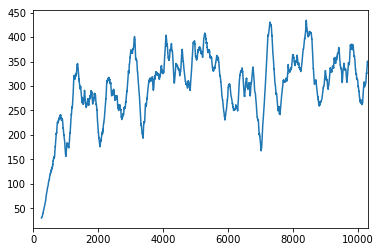

In [11]:
pd.Series(scores_list).rolling(window = 250).mean().plot();

In [87]:
state = env.reset()
state = np.reshape(state, [1, state_size])

In [38]:
action = agent.act(state)

In [88]:
for _ in range(1000):
    
    next_state, reward, done, _ = env.step(0)
    next_state, reward, done, _ = env.step(1)
    print(reward)
    
    if done: break

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [73]:
env.step(1)

(array([-0.04595386,  0.04243139,  0.02087628,  0.00347458]), 1.0, False, {})

In [9]:
pd.Series([np.log(i) for i in range(1, 100000)]).iloc[-1]

11.512915464920228